# Problema de Negocio 

Airbnb opera no mercado online de hospedagem, principalmente com casas de família para aluguel de temporada e atividade de turismo. No memento se observou a necessidade de prever o primeiro destino que um novo usuário vai escolher para fazer sua reserva de hospedagem.

**Causa raiz**: Por se tratar de um modelo de marketplace, onde visa conectar pessoas que oferecem um serviço, com pessoas que estão em busca dos mesmo, a necessidade vem de prever o destino para melhor aplicar a campanha de marketing. Buscando diminuir o CAC. 

## Planejamento da Entrega 

1. Resposta
- prever o destino do primeiro agendamento de hospedagem do usuário. 

2. Formato de entrega
- Json com os dados do cliente e a classificação do destino. 

3. Local de entrega 
- Api 

## Planejamento do Processo 

1. Extração e carregamento dos dados. 
2. Análise descritiva e  do dataset. 
3. Validação e tratamento de dados faltantes 
4. Feature engineering
5. Balanceamento dos dados. 
6. EAD.
7. Modelagem de dados
8. Seleção dos atributos relevantes 
9. Modelagem de algoritmo classificador e fine tunning
10. Criação Class Pipeline de dados e API Handler 
11. Deploy em produção 

## Planejamento de Entrada

1. Fonte dos dados 
- **kaggle** https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data
    
2. Ferramentas 
- Python 3 
- Flask 
- Sklearn 
- Jupyter Notebook 
- Heroku 

# 0.0 Import 

In [1]:
import pandas as pd 
import matplotlib.pyplot
import random

import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from keras import models as ml
from keras import layers as l
from sklearn import metrics
from scikitplot import metrics as mt
import os
    

2022-02-26 09:44:26.661885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-26 09:44:26.661919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0.1 Helper Functions 

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 0.2 Carregamento de dados 

In [3]:
df_user_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/train_users_2.csv')
# df_sessions_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/sessions.csv')

# 1.0 Análise Descritiva 

In [4]:
# verificando o a dimensao dos dados (Linhas e colunas)
# Tipo dos atributos 
df_user_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

## 1.2 Dados Faltantes ( NA ) 

In [5]:
df_user_raw.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

O dataset possui 3 colunas onde apresentam dados faltantes( NA ) 
- date_first_booking 
- age 
- first_affiliate_tracked 

## 1.3 Preenchendo NA

Como parte do primeiro ciclo de desenvolvimento focando na entrega de valor, foi adotado a exlusão das linhas com NA tendo em vista a grande redução de registros do dataset.

In [6]:
df_user_raw.dropna(inplace=True)

In [7]:
df_user_raw.shape

(68171, 16)

## 1.1 Alterando Data Type

In [9]:
df_user_raw['date_account_created'] = pd.to_datetime(df_user_raw['date_account_created'])  
df_user_raw['timestamp_first_active'] = pd.to_datetime(df_user_raw['timestamp_first_active'], format='%Y%m%d%H%M%S') 
df_user_raw['date_first_booking'] = pd.to_datetime(df_user_raw['date_first_booking'])  
df_user_raw['age'] = df_user_raw['age'].astype(int)

# 2.0 Filtragem de Atributos  

In [11]:
df2 = df_user_raw.copy()

In [12]:
#removendo atributos que nao existem no momento da predicao 
df2.drop(['id', 'timestamp_first_active', 'date_first_booking', 'date_account_created'], axis=1, inplace=True)

# 3.0 Modelagem de Dados 

In [13]:
df3 = df2.copy()

## 3.1 Encoding 

In [15]:
df3_dommies = pd.get_dummies(df3.drop('country_destination', axis=1))
df3 = pd.concat([df3_dommies, df3['country_destination']], axis=1)

# 4.0 Modelagem Machine Learning 

In [22]:
df4 = df3.copy()

## 4.1 Separar Dados Teste e Validação  

In [29]:
x = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [18]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=42)

# 4.2 Modelo Baseline

In [19]:
l_country_destination = df4['country_destination'].sort_values().unique()
country_destination_weights = df4['country_destination'].value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Modelo de classificacao aleatoria
yhat_random = random.choices(population=l_country_destination, k=k_num, weights= country_destination_weights )

## 4.2.1 Performance do Modelo - Baseline 

Acuracia:0.5208654198753209
Acuracia Balanceada: 0.0886511663214569
Kappa: 0.0036075515461582164
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        90
          CA       0.00      0.00      0.00       210
          DE       0.01      0.01      0.01       176
          ES       0.03      0.03      0.03       344
          FR       0.06      0.06      0.06       742
          GB       0.02      0.02      0.02       356
          IT       0.03      0.03      0.03       399
          NL       0.00      0.00      0.00       107
          PT       0.00      0.00      0.00        26
          US       0.71      0.71      0.71      9704
       other       0.12      0.12      0.12      1481

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.53      0.52      0.52     13635



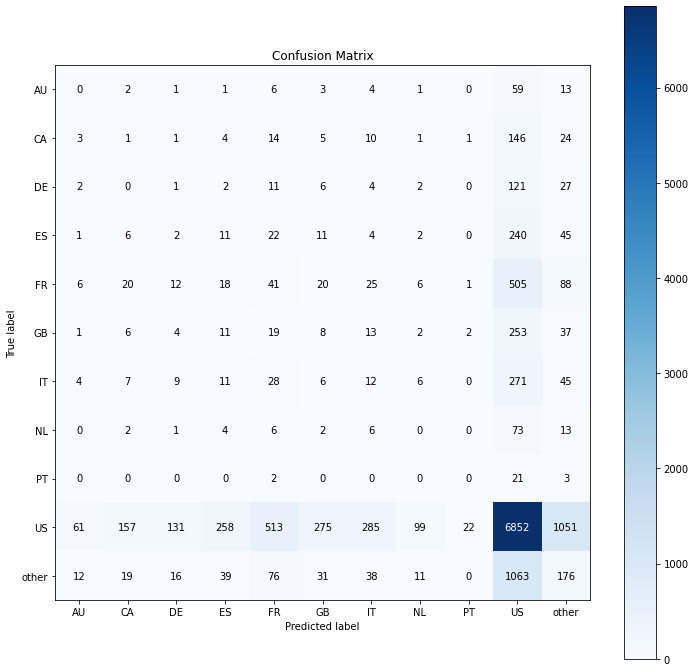

In [20]:
# acuracia 
acuracia_random = metrics.accuracy_score(y_test, yhat_random)
print('Acuracia:{}'.format(acuracia_random))

# Acuracia balanceada 
balanced_accuracy_random = metrics.balanced_accuracy_score(y_test, yhat_random)
print('Acuracia Balanceada: {}'.format(balanced_accuracy_random))

# kappa 
kappa_random = metrics.cohen_kappa_score(y_test, yhat_random)
print('Kappa: {}'.format(kappa_random))

print(metrics.classification_report(y_test, yhat_random))

# Matriz de confusao
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

# 4.3 Neural Network - MLP

In [27]:
# encode para variavel y 
encoder = pp.OneHotEncoder()
y_train_nn = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [28]:
# definicao do modelo
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation="relu"))
model.add(l.Dense(11, activation="softmax"))

# compilando modelo 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# treinamento 
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 1s 749us/step - loss: 1.3957 - accuracy: 0.7036
Epoch 2/100
1705/1705 [==============================] - 1s 766us/step - loss: 1.3123 - accuracy: 0.7060
Epoch 3/100
1705/1705 [==============================] - 1s 762us/step - loss: 1.2601 - accuracy: 0.7057
Epoch 4/100
1705/1705 [==============================] - 1s 748us/step - loss: 1.2326 - accuracy: 0.7068
Epoch 5/100
1705/1705 [==============================] - 1s 784us/step - loss: 1.2144 - accuracy: 0.7069
Epoch 6/100
1705/1705 [==============================] - 1s 746us/step - loss: 1.1897 - accuracy: 0.7071
Epoch 7/100
1705/1705 [==============================] - 1s 748us/step - loss: 1.1779 - accuracy: 0.7071
Epoch 8/100
1705/1705 [==============================] - 1s 750us/step - loss: 1.1636 - accuracy: 0.7072
Epoch 9/100
1705/1705 [==============================] - 1s 873us/step - loss: 1.1532 - accuracy: 0.7071
Epoch 10/100
 115/1705 [=>............................]

KeyboardInterrupt: 

## 4.3.1 Performance do Modelo - MLP 

In [23]:
# predicao 
pred = model.predict(x_test)

# invertendo o encoder 
yhat_nn = encoder.inverse_transform(pred)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

In [24]:
# acuracia 
acuracia_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print('Acuracia:{}'.format(acuracia_nn))

# Acuracia balanceada 
balanced_accuracy_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Acuracia Balanceada: {}'.format(balanced_accuracy_nn))

# kappa 
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa: {}'.format(kappa_nn))

print(metrics.classification_report(y_test_nn, yhat_nn))


Acuracia:0.7093509350935093
Acuracia Balanceada: 0.09181701668766137
Kappa: 0.0021522176112551694
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        90
          CA       0.25      0.00      0.01       210
          DE       0.00      0.00      0.00       176
          ES       0.20      0.00      0.01       344
          FR       0.10      0.00      0.00       742
          GB       0.00      0.00      0.00       356
          IT       0.00      0.00      0.00       399
          NL       0.00      0.00      0.00       107
          PT       0.00      0.00      0.00        26
          US       0.71      1.00      0.83      9704
       other       0.21      0.01      0.01      1481

    accuracy                           0.71     13635
   macro avg       0.13      0.09      0.08     13635
weighted avg       0.54      0.71      0.59     13635



/home/giovane/Documentos/repo/airbnb_previsao_agendamento/agendamento_airbnb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giovane/Documentos/repo/airbnb_previsao_agendamento/agendamento_airbnb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giovane/Documentos/repo/airbnb_previsao_agendamento/agendamento_airbnb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

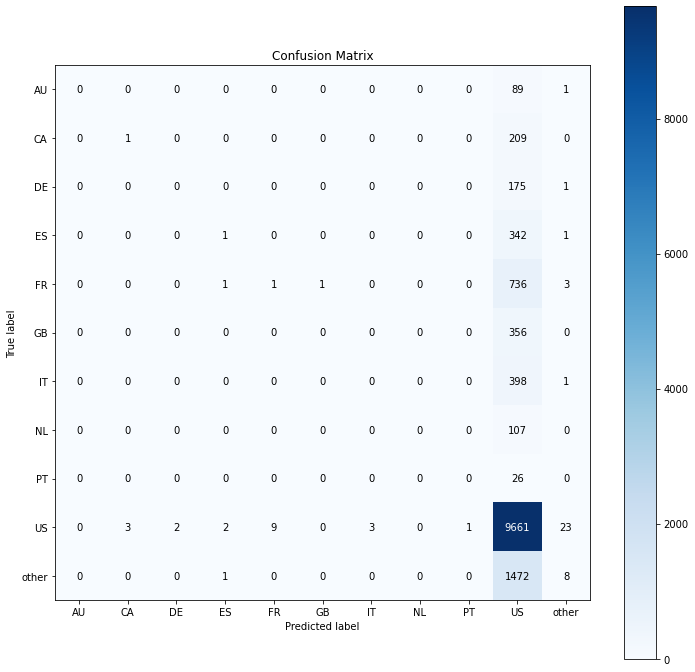

In [25]:
# Matriz de confusao
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

O modelo acabou sendo inviesado, pelo fato do dataset estar desbalanceado. Podemos ver também que a acuracia de acimade 70%, as mesma também segue sendo inviesada pelo grande número de registro com US.

## 4.3.2 Cross Validation - MLP 

In [43]:
# gerar fold 
num_fold = 5 
kfold = ms.StratifiedKFold(n_splits= num_fold, shuffle=True, random_state=42)

l_balanced_acc =[]
l_kappa = []
i=1 

for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold {}/{}'.format(i, num_fold))
    
    # fold 
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # encoder target
    encoder = pp.OneHotEncoder()
    y_train_fold_nn = encoder.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # definicao do modelo
    model = ml.Sequential()
    model.add(l.Dense(128, input_dim= x_train_fold.shape[1], activation="relu"))
    model.add(l.Dense(11, activation="softmax"))

    # compilando modelo 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    # treinamento 
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size = 42, verbose=0)

    # predicao 
    pred_nn = model.predict(x_val_fold)

    # invertendo o encoder 
    yhat_fold_nn = encoder.inverse_transform(pred_nn)

    y_val_fold_nn = y_val_fold.to_numpy()
    yhat_fold_nn = yhat_fold_nn.reshape(1,-1)[0]
    
    #metricas 
    ## Balanced Accuracy
    balanced_acc_fold = metrics.balanced_accuracy_score(y_val_fold_nn, yhat_fold_nn)
    l_balanced_acc.append(balanced_acc_fold)
    
    ##Kappa 
    kappa_fold = metrics.cohen_kappa_score(y_val_fold_nn, yhat_fold_nn)
    l_kappa.append(kappa_fold)
    
    i = i+1
    

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [51]:
print('Balanced Accuracy: {:.4f}+/-{:.4f}'.format(np.mean(l_balanced_acc), np.std(l_balanced_acc)) )
print('Kappa: {:.4f}+/-{:.4f}'.format(np.mean(l_kappa), np.std(l_kappa)) )

Balanced Accuracy: 0.0914+/-0.0002
Kappa: 0.0020+/-0.0010
